In [1]:
import galsim
from om10 import DB
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
realizer_path = os.path.join(os.environ['SLREALIZERDIR'], 'slrealizer')
sys.path.insert(0, realizer_path)
from realize_om10 import OM10Realizer
from utils.utils import *
#from realize_sl import SLRealizer

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Includes:
# 1. Determining nx, ny, and pixel scale for GalSim's drawImage and 
# 2. comparing the true and emulated images.

## 1. Checking that all functions of OM10Realizer run as expected

I write this test in a notebook because I'll need to look at images for each (nx, ny, pixel scale) configuration and qualitatively judge whether it will be okay for HSM shape estimation. First, I define the filepath for the test lens catalog and test observation history. I created these files just for testing purposes; they only have one row each.

In [2]:
data_path = os.path.join(os.environ['SLREALIZERDIR'], 'data')

test_catalog_f = os.path.join(data_path, 'test_catalog.fits')
observation_f = os.path.join(data_path, 'twinkles_observation_history.csv')

We will read them in as OM10 DB and Pandas dataframe, respectively, and use them to create our OM10Realizer object.

In [3]:
test_db = DB(catalog=test_catalog_f)
#test_db = test_db.select_random(maglim=23.3, area=18000.0, IQ=0.75)
test_db.paint(synthetic=True)

test_obs = pd.read_csv(observation_f).sample(1, random_state=123).reset_index(drop=True)

om10realizer = OM10Realizer(observation=test_obs, catalog=test_db, debug=True)

OM10: Full db.lenses table contains 1 systems
OM10: Initial db.sample contains 1 systems


These are equivalents of the lensInfo and obsInfo parameters that are input to many of the methods in OM10Realizer. We save the values to test individual methods.

In [4]:
test_lensInfo = test_db.sample[0]
test_obsInfo = test_obs.loc[0]

In [5]:
test_obsInfo

obsHistID         1907745
expMJD            62390.2
filter                  i
FWHMeff           0.98052
fiveSigmaDepth    23.4774
Name: 0, dtype: object

### 1.1 Converting OM10 catalog values into GalSim input parameters

In [6]:
galsimInput = om10realizer._from_om10_to_galsim(test_lensInfo, test_obsInfo['filter'])
galsimInput

{'beta': galsim.Angle(-2.3411096094673582, galsim.radians),
 'e': 0.1070683,
 'flux': 9.256872194542872,
 'flux_0': 0.08584389969962691,
 'flux_1': 1.4577870583563612,
 'flux_2': 4.345420449152838,
 'flux_3': 5.586665229924711,
 'half_light_radius': 0.0,
 'num_objects': 4,
 'xy_0': (-0.0375, -0.2501),
 'xy_1': (0.254, 0.3703),
 'xy_2': (-0.0772, 0.4475),
 'xy_3': (0.0071, 0.4468)}

### 1.2 Drawing the true image via GalSim's drawImage

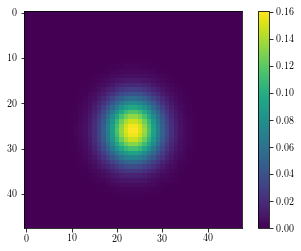

In [7]:
trueImg = om10realizer.draw_system(lensInfo=test_lensInfo, obsInfo=test_obsInfo)
plt.imshow(trueImg.array)
plt.colorbar()

### 1.3 Running HSM's shape estimation on the true image

In [8]:
hsmOutput = om10realizer.estimate_hsm(lensInfo=test_lensInfo, obsInfo=test_obsInfo)
hsmOutput

{'det': 0.45059890747070314,
 'e1': -0.12029232084751126,
 'e2': -0.0038697873242199412,
 'flux': 20.732572555541992,
 'hlr': 0.5314988575082885,
 'trace': 0.40267152723918387,
 'x': 0.05266242787101341,
 'y': 0.290778250759778}

### 1.4 Drawing the emulated image via GalSim's drawImage

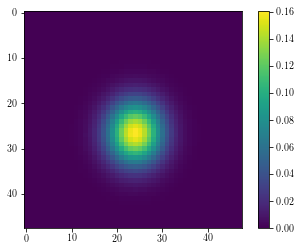

In [9]:
emulatedImg = om10realizer.draw_emulated_system(lensInfo=test_lensInfo, obsInfo=test_obsInfo)
plt.imshow(emulatedImg.array)
plt.colorbar()

## 2. Comparing the true image vs. emulated image

### 2.1 First moments x, y

Qualitatively, the two images look similar. When we take the difference of the images, it seems that their centers have a slight offset. Let's investigate why.

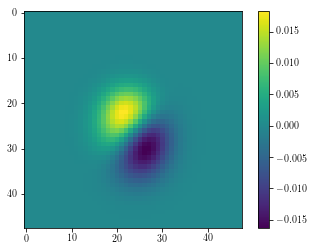

In [10]:
plt.imshow(trueImg.array-emulatedImg.array)
plt.colorbar()

In [11]:
estEmulated = emulatedImg.FindAdaptiveMom()
pixel_to_physical(estEmulated.moments_centroid.x, om10realizer.nx, om10realizer.pixel_scale)

0.09900822165367913

### 2.2 Second moments (half-light radius)

If the shear is not too dramatic, `calculateHLR` works fairly well to estimate the true HLR. Let us first compare the HLR of the emulated image to the true HLR.

In [12]:
from utils.utils import physical_to_pixel
phys_x = physical_to_pixel(hsmOutput['x'], canvasSize=om10realizer.nx, pixel_scale=om10realizer.pixel_scale)
phys_y = physical_to_pixel(hsmOutput['y'], canvasSize=om10realizer.ny, pixel_scale=om10realizer.pixel_scale)
pixelCenter = galsim.PositionD(x=phys_x, y=phys_y)

In [13]:
emulated_hlr = emulatedImg.calculateHLR(center=pixelCenter)

The HLRs of the true and emulated images do not agree to floating-point precision.

In [14]:
print(np.allclose(hsmOutput['hlr'], emulated_hlr))
print(hsmOutput['hlr'], emulated_hlr)

False
(0.5314988575082885, 0.5367157266869247)


It turns out that the emulated image is 1% bigger!

In [15]:
print((emulated_hlr-hsmOutput['hlr'])/hsmOutput['hlr'])

0.009815391143253435


We've compared the half-light radius, but what goes in the source table (and stored in `hsmOutput['trace']`) is the trace of the second moment from `calculateMomentRadius(rtype='trace')`

In [16]:
hsmOutput['trace']

0.40267152723918387

### 2.3 Flux

It doesn't make sense to use HSM's flux estimation (`moments.amp`) when we have access to the true flux, i.e. the sum of the lens flux and the four (quasar) image fluxes is the true total flux. So we bypass HSM and store the sum of the true image's pixel values as flux. So we expect that the flux values of true and emulated images agree within floating-point precision.

In [17]:
l_flux = galsimInput['flux']
g_fluxes = [galsimInput['flux_' + str(i)] for i in range(4)]
true_tot_flux = l_flux + np.sum(g_fluxes)
print(np.allclose(true_tot_flux, hsmOutput['flux']))

True
